## XGBoost Strategy: Himanshu Kumar

In [1]:
import pandas as pd
import numpy as np
import time
import json
import talib as ta
import warnings
import pyfolio as pf
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over_sampler = RandomOverSampler()
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import plotly.graph_objs as go

import ipywidgets as widgets
from ipywidgets import interact
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

C:\Users\hksci\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


### Df and Features

In [2]:
def add_pivots(df_daily):
    df_daily["Pivot"] = df_daily[[ 'High', 'Low', 'Close']].mean(axis =1).round(2).shift(1)
    df_daily["Bcpr"]  = df_daily[[ 'High', 'Low'        ]].mean(axis =1).round(2).shift(1)
    df_daily["Tcpr"]  = 2 * df_daily["Pivot"] - df_daily["Bcpr"] 
    df_daily["H3"]    = (df_daily["Close"] + (df_daily["High"] - df_daily["Low"])* 1.1/4).round(2).shift(1)
    df_daily["H4"]    = (df_daily["Close"] + (df_daily["High"] - df_daily["Low"])* 1.1/2).round(2).shift(1)
    df_daily["L3"]    = (df_daily["Close"] - (df_daily["High"] - df_daily["Low"])* 1.1/4).round(2).shift(1)
    df_daily["L4"]    = (df_daily["Close"] - (df_daily["High"] - df_daily["Low"])* 1.1/2).round(2).shift(1)

    df_daily["width"] = df_daily["H4"] - df_daily["H3"] 
    df_daily["H3_in_CPR"] =  ((df_daily['H3'] < df_daily['Pivot'])).astype(int)
    df_daily["L3_in_CPR"] =  ((df_daily['L3'] > df_daily['Pivot'])).astype(int)
    df_daily["BC>TC"] = (df_daily["Bcpr"] > df_daily["Tcpr"] ).astype(int)
    
    return df_daily

In [3]:
def pre_process():
    df = pd.read_csv("BNF_1min.csv")

    # select columns to round
    cols_to_round = ['O', 'H', 'L', 'C', 'VWAP', 'AdjFac', 'CaxFac',"rolling_vol"]

    # round columns to 2 decimal places
    df[cols_to_round] = df[cols_to_round].round(2)

    # rename columns
    df = df.rename(columns={'O': 'Open', 'H': 'High', 'L': 'Low', 'C': 'Close', "V" : "Volume"})

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')

    # Resample to daily OHLC data
    ohlc_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last','Volume': 'sum', 'VWAP': 'mean'}
    df_daily = df.resample('D').agg(ohlc_dict)
    df_daily.dropna(inplace = True)
    
    #add pivot_levels
    df_daily = add_pivots(df_daily)
    
    # merge daily, Join `df_daily` and `df`
    df["timestamp"] =  df.index
    df['Date'] = df.index.date
    df['Time'] = df['timestamp'].dt.strftime('%H:%M:%S')
    df_daily['Date'] = df_daily.index.date

    columns_to_merge = ['Date','Pivot','Bcpr', 'Tcpr', 'H3', 'H4', 'L3', 'L4','width', 'H3_in_CPR', 'L3_in_CPR','BC>TC']
    merged_df = pd.merge(df, df_daily[columns_to_merge], on= 'Date')
    merged_df.drop(columns = ["Date"], inplace = True)
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
    merged_df = merged_df.set_index('timestamp')
    
    #dropna before buy_sell
    merged_df.dropna(inplace = True)
    
    return merged_df

In [4]:
def add_indicators(df):
    df['avg_high_and_low']=(df['High']+df['Low'])/2
    df['ADX']=ta.ADX(df['High'],df['Low'],df['Close'],timeperiod=50)
    df['RSI']=ta.RSI(df['Close'],timeperiod=50)
    df['AO']=(ta.SMA(df['avg_high_and_low'], timeperiod=5)-ta.SMA(df['avg_high_and_low'], timeperiod=34))
    df['ATR']=ta.ATR(df['High'],df['Low'],df['Close'],timeperiod=21)

    body = abs(df["High"]- df["Low"])
    df["ATR_Condn"] = body > df['ATR']
    
    df["AO_Cond"] = df["AO"]>0
    df["VWAP_Cond"] = df["VWAP"] < df["Close"]
    
    # Add Awesome Oscillator
    ao = df["AO"]
    ao1=df['AO'].shift(1)
    ao2=df['AO'].shift(2)
    ao3=df['AO'].shift(3)
    ao4=df['AO'].shift(4)

    #at current c&le
    df["AO_DU"] = (ao<ao1) & (ao1<ao2) & (ao2>ao3) & (ao3>ao4)
    df["AO_U"]  = (ao>ao1) & (ao1>ao2) & (ao2<ao3) & (ao3<ao4) 

    df['positive_to_negative'] = (df['AO'] > 0) & (df['AO'].shift(1) > 0) & (df['AO'] < df['AO'].shift(1)) 
    df['negative_to_positive'] = (df['AO'] < 0) & (df['AO'].shift(1) < 0) & (df['AO'] > df['AO'].shift(1))
    
    df["SMA_750"] = ta.SMA(df['Close'],timeperiod= 750).round(2)
    df["P>750SMA"] = (df["Close"] > df["SMA_750"]).astype(int)
    
    df["SMA_300"] = (ta.SMA(df['Close'],timeperiod= 300).round(2))  
    df["P>300SMA"] = (df["Close"] > df["SMA_300"]).astype(int)
    
    df.dropna(inplace = True)
    
    return df

In [5]:
def add_signals(df):
    
    df["buy"]  = df["AO_U"] & (df["Close"] > df["L4"]) & df["P>750SMA"] 
    df["sell"]   = df["AO_DU"] & (df["Close"] < df["H4"]) 

    # calculate the crossover signal, for agressive trailing
    df["SMA_cross_d"] = (df["Close"] > df["SMA_300"]) & (df["Close"].shift(1) < df["SMA_300"].shift(1))
    df["SMA_cross_u"] = (df["Close"] < df["SMA_300"]) & (df["Close"].shift(1) > df["SMA_300"].shift(1))

    df["exit_buy_profit"] =  df["SMA_cross_d"] & df["P>750SMA"] &  (df["Close"] > df["Tcpr"])
    df["exit_sell_profit"] = df["SMA_cross_u"] & (df["P>750SMA"] == False) & (df["Close"] < df["Bcpr"])

    n1 = 3
    df["Buy_Target"] = df["Close"] + (n1 * df["ATR"])

    n2 = 3
    df["Sell_Target"] = df["Close"] - (n2 * df["ATR"])

    m1 = 3
    df["Buy_SL"] = df["Close"] - (m1 * df["ATR"])

    m2 = 3
    df["Sell_SL"] = df["Close"] + (m2 * df["ATR"])
    
    
    
#     df["buy"]    = df["AO_U"] & df["P>750SMA"] & (df["Close"] > df["L4"])
#     df["sell"]   = df["AO_DU"] & (df["P>750SMA"]==False) & (df["Close"] < df["H4"]) 
    
    return df

In [6]:
def backtest(df):
    
    pos = 0
    target = 0
    sl = 0
    enter_price = 0
    store_i = 1
    
    df["Exit_Signal"] = None
    df["Sell_Signal"] = None
    df["Pos"] = 0
    df["Signal_name"]=None
    df["returns"] = 0

    
    for i in range(1, len(df)-1):

        if pos == 0: 

            if df["buy"].iloc[i]:
                store_i = i
                pos = 1
                df["Pos"].iloc[i] = 1

                enter_price = df["Open"].iloc[i+1]
                df["Signal_name"].iloc[i]= 'Supertrend Buy'

                target = df["Buy_Target"].iloc[i] 
                sl     = df["Buy_SL"].iloc[i]

            elif df["sell"].iloc[i] : 
                store_i = i

                df["Pos"].iloc[i] = -1
                pos = -1

                enter_price = df["Open"].iloc[i+1]
                df['Signal_name'].iloc[i]='Supertrend Sell'

                target =  df["Sell_Target"].iloc[i] 
                sl     =  df["Sell_SL"].iloc[i]


        elif pos == 1:

            if ((df['Close'].iloc[i] < sl ) | df['positive_to_negative'].iloc[i] | (df['Close'].iloc[i] > target )):
                df["Pos"].iloc[i] = 0
                pos = 0
                df["Exit_Signal"].iloc[i] = 1

                df["returns"].iloc[store_i] =  ((df['Open'].iloc[i+1] - enter_price) /enter_price)

                if (df['Close'].iloc[i] < sl ):
                    df['Signal_name'].iloc[i]='Exit Buy SL Hit'

                elif (df['Close'].iloc[i] > target ):
                    df['Signal_name'].iloc[i]='Exit Buy Target Hit'

                else :
                    df['Signal_name'].iloc[i]='positive_to_negative'

            elif df["exit_buy_profit"].iloc[i] :

                df["Pos"].iloc[i] = 0
                pos = 0            
                df["returns"].iloc[store_i] = ((df['Open'].iloc[i+1] - enter_price) /enter_price)
                df['Signal_name'].iloc[i] = 'exit_buy_profit'

        elif pos == -1:

            if ((df['Close'].iloc[i] > sl ) |  df['negative_to_positive'].iloc[i] | (df['Close'].iloc[i] < target ) ):
                df["Pos"].iloc[i] = 0
                pos = 0
                df["Exit_Signal"].iloc[i] = 1

                df["returns"].iloc[store_i] = ((enter_price - df['Open'].iloc[i+1] ) /enter_price)
                if (df['Close'].iloc[i] > sl ):
                    df['Signal_name'].iloc[i]='Exit Sell SL Hit'

                elif (df['Close'].iloc[i] < target ):
                    df['Signal_name'].iloc[i]='Exit Sell Target Hit'

                else :
                    df['Signal_name'].iloc[i]='negative_to_positive'

            elif df["exit_sell_profit"].iloc[i] :

                df["Pos"].iloc[i] = 0
                pos = 0

                df["returns"].iloc[store_i] =((enter_price - df['Open'].iloc[i+1]) /enter_price)
                df['Signal_name'].iloc[i] = 'exit_sell_profit'
                
    return df

In [7]:
def post_trade_stats(df):
    print(df["Pos"].value_counts())
    pf.display(pf.create_simple_tear_sheet(np.log(1+df[df["Pos"] != 0]['returns'])))
    df["Profitable"] = (df["returns"] > 0)
    print(f"Profitable trades: {df['Profitable'].sum()}")
    
    return df

## Model Development

In [8]:
def XGBoost_dataprep(df,train_set=0.8):
    
    df_train = df[df["Pos"] != 0]
    
    Features= ['ADX', 'RSI', 'ATR',"VWAP_Cond","width"]
    X = df_train[Features]
    y = df_train["Profitable"]
       
    cutoff = int(len(df_train)*train_set)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test   = X[cutoff:], y[cutoff:]
    
    X_train_over, y_train_over = over_sampler.fit_resample(X,y)


    # Plot class balance
    df_train["Profitable"].value_counts().plot(kind="bar",
    xlabel = "Profitable", ylabel = "frequency", title = "Class Balance"
    );
    
    return X_train_over,y_train_over,X_test,y_test,Features

In [9]:
def train_model(X,y,n_splits=5):
    
    X = X.to_numpy()
    y = y.to_numpy()
    # Create an XGBoost classifier model
    model = xgb.XGBClassifier(learning_rate=0.01,
                              max_depth=6,
                              n_estimators=5000)

    # Create a cross-validation object
    kf = KFold(n_splits)

    # Initialize lists to store the scores for each fold
    train_scores = []
    test_scores = []

    # Loop through each fold
    for train_idx, test_idx in kf.split(X):
        
        # Split the data into training and test sets for the current fold
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        eval_set = [(X_test, y_test)]

        # Train the model on the training data
        model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=15)

        # Evaluate the model on the training data
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)

        # Evaluate the model on the test data
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)

    # Compute and print the mean and standard deviation of the scores
    print(f"Train Scores: {np.mean(train_scores):.3f} +/- {np.std(train_scores):.3f}")
    print(f"Test Scores: {np.mean(test_scores):.3f} +/- {np.std(test_scores):.3f}")
    
   
    return model 

In [10]:
def model_trade(df,model,features):
    
    def make_cnf_matrix(threshold):
        test_df = df[df["Pos"] != 0]
        X = test_df[features]

        y_pred_proba = model.predict_proba(X)[:,-1]
        y_pred = y_pred_proba > threshold


        test_df["y_pred"] = y_pred
        test_df["returns_model"] = test_df["returns"] * (test_df["y_pred"])

        pf.display(pf.create_simple_tear_sheet(np.log(1+test_df['returns_model'])))

    thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5,step=0.05)

    interact(make_cnf_matrix, threshold=thresh_widget);
    
    return df

 0    85450
-1     2911
 1     1639
Name: Pos, dtype: int64


Start date,2021-03-10
End date,2022-03-07
Total months,216
,Backtest
Annual return,-0.3%
Cumulative returns,-4.6%
Annual volatility,3.6%
Sharpe ratio,-0.06
Calmar ratio,-0.02
Stability,0.13
Max drawdown,-13.1%


None

Profitable trades: 2212


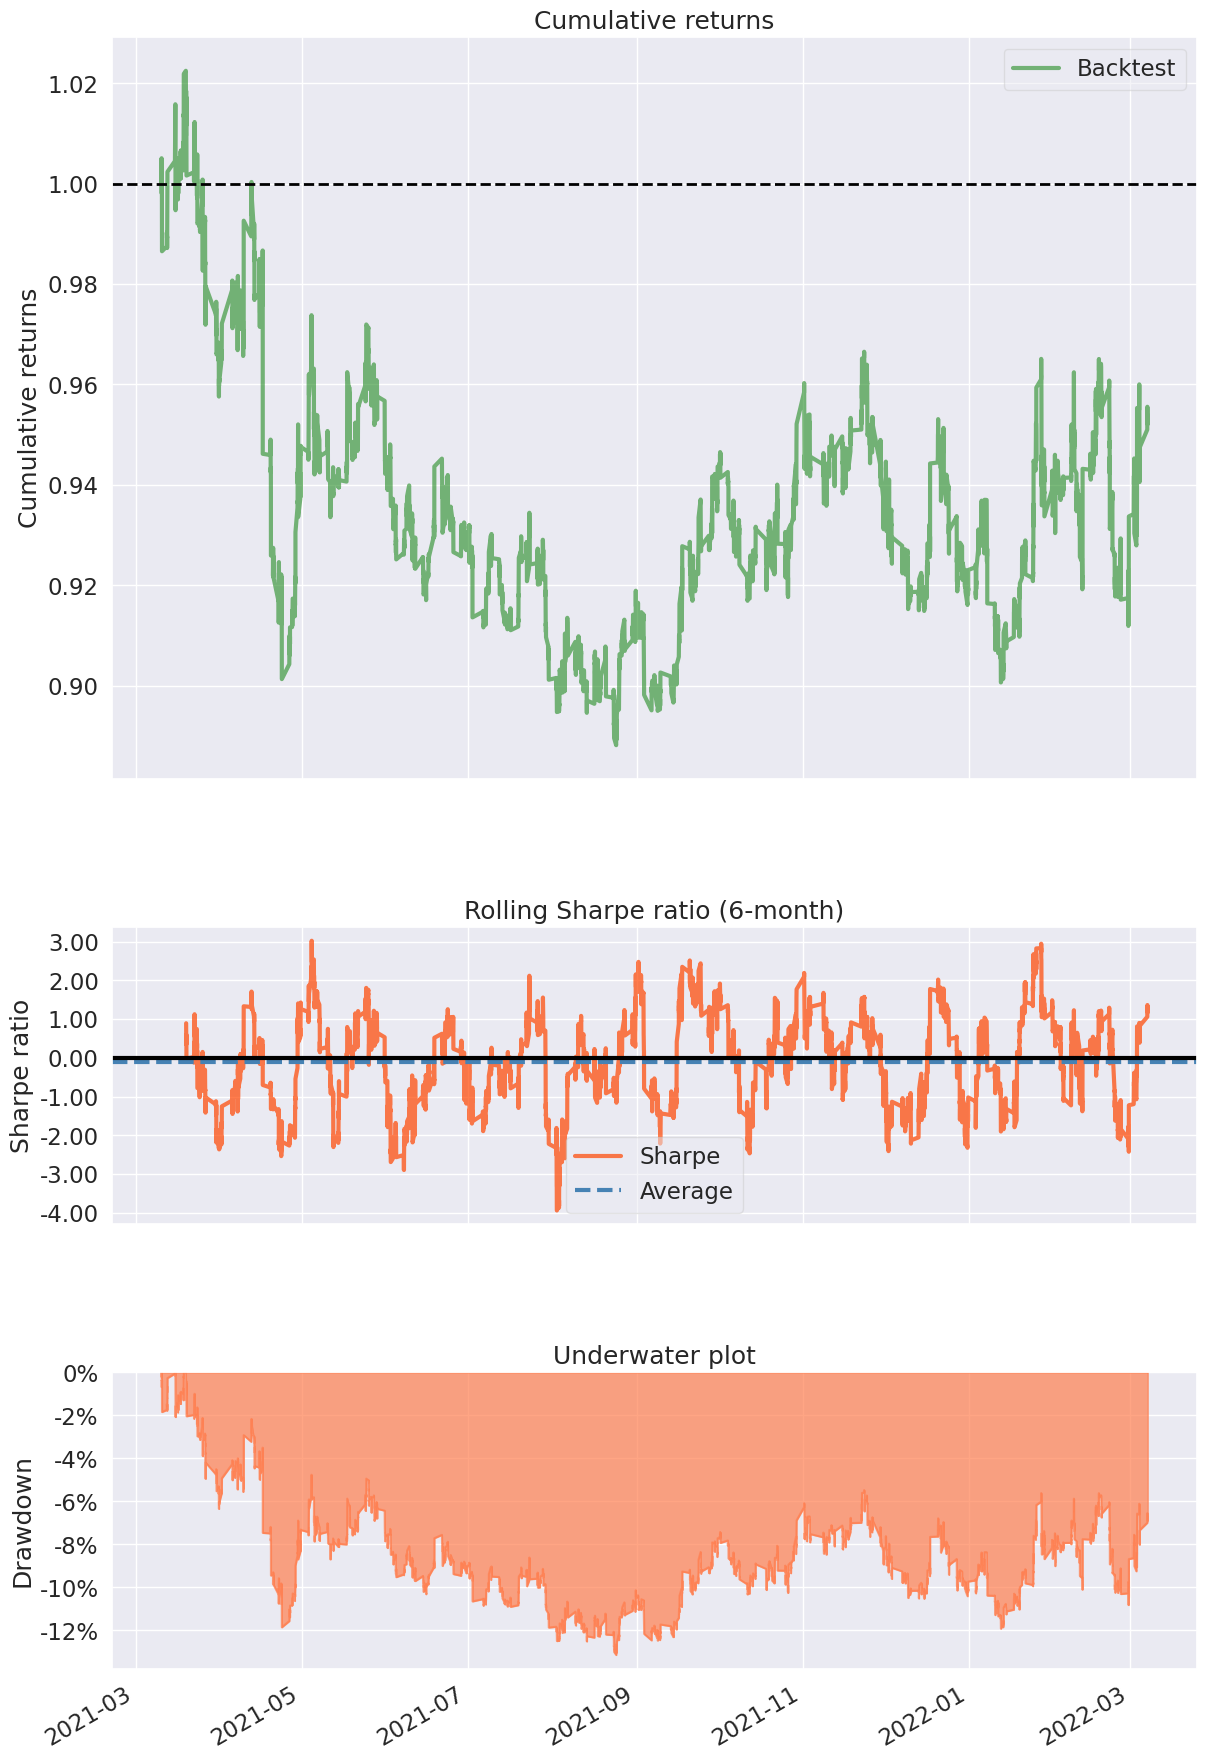

In [11]:
data = pre_process()
data = add_indicators(data)
data = add_signals(data)
data = backtest(data[:90000])
data = post_trade_stats(data)

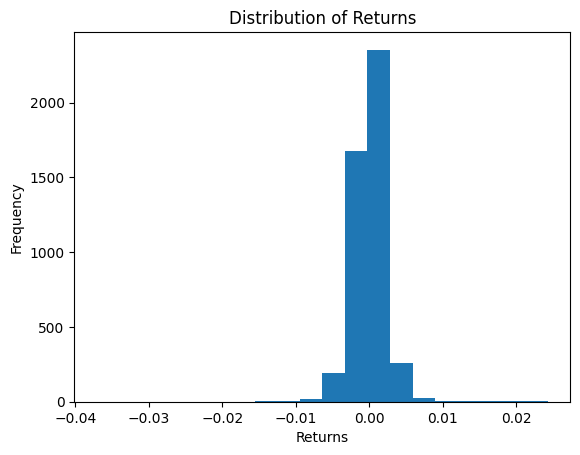

In [13]:
returns = data[data["Pos"] != 0]["returns"]

# Create a histogram of the returns
plt.hist(returns, bins=20)
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title("Distribution of Returns")
plt.show()

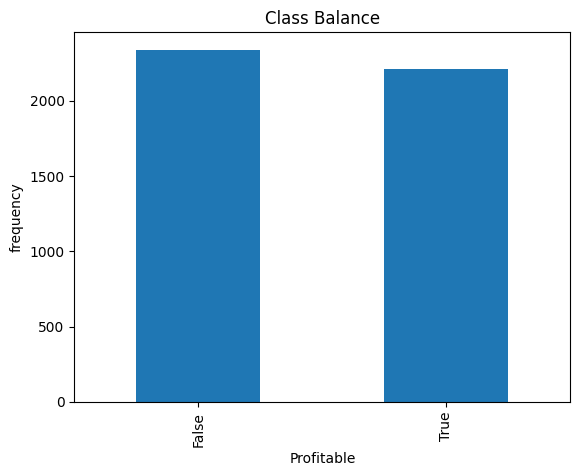

In [15]:
X,y,X_test,y_test,features = XGBoost_dataprep(data)


In [16]:
model = train_model(X,y)

[0]	validation_0-logloss:0.69298
[1]	validation_0-logloss:0.69281
[2]	validation_0-logloss:0.69271
[3]	validation_0-logloss:0.69264
[4]	validation_0-logloss:0.69256
[5]	validation_0-logloss:0.69247
[6]	validation_0-logloss:0.69237
[7]	validation_0-logloss:0.69231
[8]	validation_0-logloss:0.69226
[9]	validation_0-logloss:0.69227
[10]	validation_0-logloss:0.69227
[11]	validation_0-logloss:0.69226
[12]	validation_0-logloss:0.69229
[13]	validation_0-logloss:0.69235
[14]	validation_0-logloss:0.69236
[15]	validation_0-logloss:0.69239
[16]	validation_0-logloss:0.69240
[17]	validation_0-logloss:0.69243
[18]	validation_0-logloss:0.69247
[19]	validation_0-logloss:0.69251
[20]	validation_0-logloss:0.69253
[21]	validation_0-logloss:0.69259
[22]	validation_0-logloss:0.69265
[23]	validation_0-logloss:0.69269
[0]	validation_0-logloss:0.69317
[1]	validation_0-logloss:0.69319
[2]	validation_0-logloss:0.69324
[3]	validation_0-logloss:0.69326
[4]	validation_0-logloss:0.69329
[5]	validation_0-logloss:0.69

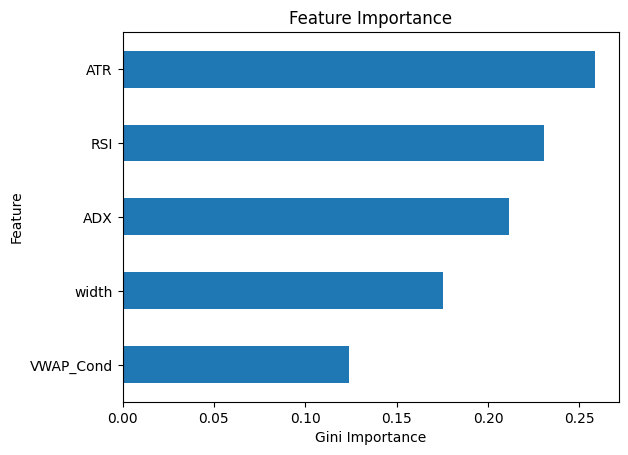

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [17]:
# Get the feature importances
importances = model.feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values()

# Plot 10 most important features
feat_imp.tail(20).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");


def make_cnf_matrix(threshold):
    
    y_pred_proba = model.predict_proba(X_test)[:,-1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test,y_pred)
    tn,fp,fn,tp = conf_matrix.ravel()

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, colorbar = False)     

thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5,step=0.05)
interact(make_cnf_matrix, threshold=thresh_widget);

In [18]:
data = pre_process()
data = add_indicators(data)
data = add_signals(data)
data = backtest(data[90000:])
df = model_trade(data,model,features)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…